## Analyzing Europe's atmospheric pollution levels using CAMS PM10 data 🛰️🏭

#### Goal: 
to find out which places in Europe were characterized by exceedingly high PM10 concentration levels

#### Data:
- Copercnicus Atmospheric Monitoring Service (CAMS) hourly data on PM10 concentration levels available at: https://www.regional.atmosphere.copernicus.eu/?category=data_access (later moved to: https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-reanalyses?tab=overview)

#### Example area & time: 
Europe, year of 2012

#### Processing steps:
1. Initial preparation
2. Familiarinig with the data
3. Transforming the type of 'time' variable
4. Aggregating hourly data to create a daily product
5. Calculating the number of days characterized by exceedingly high PM10 values, for each place (pixel) in Europe
6. Saving the result as a TIFF file using GDAL

Prepared by: Aleksandra Radecka <br>
e-mail: aleksandraradecka@protonmail.com <br>
LinkedIn: https://www.linkedin.com/in/aleksandraradecka/

## 1. Initial preparation

In [1]:
import os

import numpy as np
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import pandas as pd
import xarray as xr

In [2]:
folder = r'C:\3_cams'

In [3]:
pm10_path = os.path.join(folder, r'ENSa.2012.PM10.yearlyrea.nc')

## 2. Familiarinig with the data

In [4]:
pm10_ds = xr.open_mfdataset(pm10_path)

C:\Users\aleks\.conda\envs\drought_env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aleks\.conda\envs\drought_env\lib\site-packages\xarray\backends\api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [6]:
pm10_ds

<xarray.Dataset>
Dimensions:  (time: 8784, x: 701, y: 401)
Coordinates:
  * time     (time) float64 2.012e+07 2.012e+07 ... 2.012e+07 2.012e+07
Dimensions without coordinates: x, y
Data variables:
    lon      (y, x) float32 dask.array<chunksize=(401, 701), meta=np.ndarray>
    lat      (y, x) float32 dask.array<chunksize=(401, 701), meta=np.ndarray>
    PM10     (time, y, x) float32 dask.array<chunksize=(8784, 401, 701), meta=np.ndarray>
Attributes:
    CDI:                 Climate Data Interface version 1.4.7 (http://code.zm...
    Conventions:         CF-1.0
    history:             Mon Jul 28 10:16:49 2014: cdo enspctl,50 /SMT/C1/MAC...
    Sub-title:           Hourly output concentrations file
    Generating_process:  Generated by anthony.ung@ineris.fr
    Domain:              GEMSH
    Associated_Project:  MACC2
    CDO:                 Climate Data Operators version 1.4.7 (http://code.zm...

Comment: We can observe that the PM10 variable's data are modelled on an hourly time step => 366 days x 24 h = 8784 values. This is why 8784 appears as the size of 'time'.  

In [7]:
pm10_da = pm10_ds['PM10']

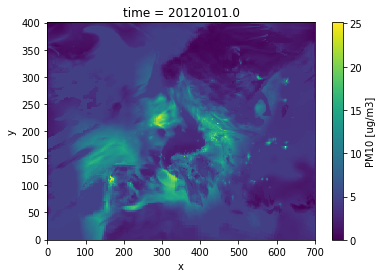

In [8]:
# plotting the 1st observation 
pm10_da[0].plot();

Comment: We can observe that the 'time' variable is not of type 'datetime64', but 'float64'. Performing operations related to time will therefore require transforming the data first. According to Xarray Authors' recommendations presented <a href="http://xarray.pydata.org/en/stable/time-series.html">here</a>, a Pandas function should be used to do so.

## 3. Transforming the type of 'time' variable

In [9]:
pm10_time_na = pm10_ds['time'].values

In [10]:
pm10_time_df = pd.DataFrame(pm10_time_na, columns=['col1'])

In [11]:
pm10_time_df.head()

,col1
0,2.012010e+07
1,2.012010e+07
2,2.012010e+07
3,2.012010e+07
4,2.012010e+07


In [12]:
pm10_time_df['col1'] = pd.to_datetime(pm10_time_df['col1'], format='%Y%m%d')

In [13]:
# the information of the hour was omitted - all hours within a specific day have the same col1 value
pm10_time_df.head()

,col1
0,2012-01-01
1,2012-01-01
2,2012-01-01
3,2012-01-01
4,2012-01-01


In [15]:
# new Xarray DataArray preparation
z_time_nn = pm10_time_df.col1.values 
z_lat_l = pm10_ds.lat.values[:,0].tolist() 
z_lon_l = pm10_ds.lon.values[0,:].tolist() 
z_pm10_nn = pm10_ds.PM10.values 

In [16]:
# new Xarray DataArray creation
pm10new_da = xr.DataArray(data=z_pm10_nn, \
                          coords=[z_time_nn, z_lat_l, z_lon_l], dims=['time', 'lat', 'lon'])

In [17]:
pm10new_da

<xarray.DataArray (time: 8784, lat: 401, lon: 701)>
array([[[ 4.6859083 ,  4.6859083 ,  4.6859083 , ...,  3.3873136 ,
          3.4162128 ,  3.5081334 ],
        [ 4.6897106 ,  4.6875496 ,  4.6859803 , ...,  3.3890712 ,
          3.3890712 ,  3.4759583 ],
        [ 4.6908894 ,  4.6908894 ,  4.690297  , ...,  3.3890712 ,
          3.3890712 ,  3.416683  ],
        ...,
        [ 0.05931028,  0.05846719,  0.05668691, ...,  0.79110575,
          0.77308637,  0.7354163 ],
        [ 0.06932073,  0.06811352,  0.06544195, ...,  0.8903847 ,
          0.86479986,  0.22449858],
        [ 0.        ,  0.        ,  0.        , ...,  0.73138565,
          0.7314607 ,  0.3681487 ]],

       [[ 5.167272  ,  8.738514  ,  8.738663  , ..., 13.485692  ,
         13.487074  ,  6.7436223 ],
        [ 8.740905  , 17.48151   , 17.48181   , ..., 24.854353  ,
         21.874191  , 13.490704  ],
        [ 8.740904  , 12.925586  , 13.025929  , ..., 19.167255  ,
         17.043001  , 13.490703  ],
        ...,
        [ 0.7787285 ,  0.83258826,  0.8864479 , ...,  1.5471654 ,
          1.5473238 ,  1.2319258 ],
        [ 0.65002453,  0.7161192 ,  0.78221375, ...,  1.5471653 ,
          1.547324  ,  0.7784871 ],
        [ 0.14920361,  0.15180896,  0.15296572, ...,  1.4920253 ,
          1.4933002 ,  1.4945751 ]],

       [[ 4.3134694 ,  8.626791  ,  8.626939  , ..., 12.829377  ,
         12.830692  ,  6.4154873 ],
        [ 8.629151  , 14.50958   , 14.49658   , ..., 21.504766  ,
         18.688332  , 12.834266  ],
        [ 8.629151  , 12.754876  , 13.005788  , ..., 15.947123  ,
         16.702948  , 12.834265  ],
        ...,
        [ 0.16254622,  0.17330216,  0.17330511, ...,  1.6634707 ,
          1.6636411 ,  1.0761787 ],
        [ 0.18575731,  0.18545005,  0.1816034 , ...,  1.6634705 ,
          1.6636412 ,  0.8366378 ],
        [ 0.04337819,  0.08675489,  0.08675637, ...,  1.2852782 ,
          1.2827281 ,  1.2801782 ]],

       ...,

       [[ 6.469016  , 12.937812  , 12.938032  , ..., 21.587614  ,
         17.25275   , 15.43635   ],
        [12.941352  , 15.59853   , 15.69065   , ..., 22.82965   ,
         22.570457  , 15.57931   ],
        [12.941351  , 15.68347   , 15.75336   , ..., 23.334011  ,
         23.561481  , 15.71216   ],
        ...,
        [ 0.08921994,  0.17843683,  0.17843987, ...,  3.734971  ,
          1.6828012 ,  2.5711865 ],
        [ 0.08921994,  0.17843682,  0.17843986, ...,  3.793958  ,
          1.7337227 ,  1.1517664 ],
        [ 0.03520087,  0.0379594 ,  0.0413402 , ...,  2.5694182 ,
          2.5696816 ,  1.2871336 ]],

       [[ 5.9626803 , 11.925156  , 11.925361  , ..., 21.691286  ,
         21.615608  , 12.50033   ],
        [11.92842   , 12.8121    , 12.98598   , ..., 25.643454  ,
         25.646082  , 12.824826  ],
        [11.928419  , 12.99017   , 13.14159   , ..., 25.643452  ,
         25.646082  , 12.92847   ],
        ...,
        [ 0.08874901,  0.177495  ,  0.17749801, ...,  4.605456  ,
          1.6232312 ,  2.564661  ],
        [ 0.08874901,  0.17749499,  0.17749801, ...,  4.941143  ,
          1.6406453 ,  1.0757687 ],
        [ 0.03538168,  0.03858924,  0.04296303, ...,  2.5628846 ,
          2.5631473 ,  1.2838669 ]],

       [[ 5.4858603 , 10.971533  , 10.971721  , ..., 21.608255  ,
         21.602072  , 11.46592   ],
        [10.974536  , 11.86927   , 12.10773   , ..., 27.936094  ,
         27.938961  , 13.97095   ],
        [10.974535  , 12.1341    , 12.33591   , ..., 27.936094  ,
         27.93896   , 13.970948  ],
        ...,
        [ 0.0887402 ,  0.17747736,  0.1774804 , ...,  2.885894  ,
          1.5390066 ,  1.801885  ],
        [ 0.0887402 ,  0.17747736,  0.17748038, ...,  2.971815  ,
          1.5209329 ,  0.9838449 ],
        [ 0.03601839,  0.04064472,  0.04544635, ...,  2.527506  ,
          2.5277655 ,  1.2661783 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2012-01-01 ... 2012-12-31
  * lat      (lat) float64 30.0 30.1 30.2 30.3 30.4 ... 69.6 69.7 69.8 69

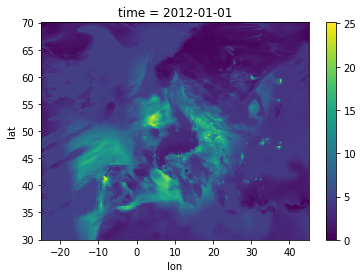

In [18]:
# plotting the 1st observation again
pm10new_da[0].plot();

## 4. Aggregating hourly data to create a daily product 

In [19]:
pm10_daily_da = pm10new_da.resample(time='1D').mean()

In [20]:
# indeed 366 resultant maps
pm10_daily_da

<xarray.DataArray (time: 366, lat: 401, lon: 701)>
array([[[ 4.112526  ,  6.1765084 ,  6.176601  , ...,  5.9499288 ,
          6.1999516 ,  4.473067  ],
        [ 6.2884984 , 10.48684   , 10.500876  , ..., 11.499654  ,
         11.39479   ,  8.153602  ],
        [ 6.3327312 ,  9.862903  ,  9.913198  , ..., 11.031123  ,
         11.572849  ,  9.152974  ],
        ...,
        [ 0.24166171,  0.24064136,  0.23767173, ...,  1.6827775 ,
          1.4872866 ,  1.2592927 ],
        [ 0.26320052,  0.2576359 ,  0.25250044, ...,  1.7412372 ,
          1.5193981 ,  0.87449884],
        [ 0.14652258,  0.14497626,  0.1419111 , ...,  1.4689511 ,
          1.4655393 ,  1.1786083 ]],

       [[ 4.553343  ,  5.6382337 ,  5.6382995 , ...,  2.6390722 ,
          2.692831  ,  2.8921645 ],
        [ 5.633423  ,  9.702882  ,  9.707931  , ...,  3.5838802 ,
          3.5842478 ,  2.8111217 ],
        [ 5.6555614 ,  9.683182  ,  9.686379  , ...,  3.5838802 ,
          3.5842476 ,  2.6893494 ],
        ...,
        [ 0.08127432,  0.11670813,  0.11922414, ...,  1.6764756 ,
          1.5922607 ,  1.2665969 ],
        [ 0.08574507,  0.12971617,  0.13096102, ...,  1.656188  ,
          1.5640281 ,  0.7851529 ],
        [ 0.0500562 ,  0.06484656,  0.06427812, ...,  1.5891414 ,
          1.5914732 ,  0.9791742 ]],

       [[ 4.47745   ,  5.3133426 ,  5.3133755 , ...,  4.1728544 ,
          4.1113286 ,  3.7874887 ],
        [ 5.0860314 ,  7.3905826 ,  7.412606  , ...,  5.157175  ,
          5.185209  ,  3.899706  ],
        [ 5.0187287 ,  6.773863  ,  6.803885  , ...,  5.0739346 ,
          5.0962586 ,  3.8815231 ],
        ...,
        [ 0.08523636,  0.156291  ,  0.1577682 , ...,  1.3755106 ,
          1.2487    ,  1.0976815 ],
        [ 0.09164666,  0.15346019,  0.15535258, ...,  1.381939  ,
          1.2484962 ,  0.72646505],
        [ 0.04337628,  0.06888416,  0.06844153, ...,  1.1539487 ,
          1.1499884 ,  0.73748446]],

       ...,

       [[11.065059  , 13.553783  , 13.729327  , ..., 16.689232  ,
         16.660507  , 12.288097  ],
        [12.084584  , 14.31895   , 14.710164  , ..., 20.06216   ,
         20.121092  , 12.757636  ],
        [11.454637  , 13.48445   , 13.57162   , ..., 20.201948  ,
         20.258972  , 12.695792  ],
        ...,
        [ 0.11578476,  0.16807152,  0.1620759 , ...,  1.4500214 ,
          1.3791232 ,  1.174057  ],
        [ 0.11639138,  0.17141575,  0.16560741, ...,  1.4436256 ,
          1.3638979 ,  0.54469734],
        [ 0.04264561,  0.06342406,  0.06145478, ...,  1.3251115 ,
          1.3252474 ,  0.6650015 ]],

       [[17.522001  , 25.72719   , 25.646294  , ..., 21.09648   ,
         20.212881  , 11.748677  ],
        [26.077414  , 27.92034   , 27.758768  , ..., 22.694992  ,
         22.274294  , 12.886298  ],
        [26.197655  , 28.571218  , 28.45799   , ..., 22.503235  ,
         21.98215   , 12.891435  ],
        ...,
        [ 0.09390212,  0.15429576,  0.15139093, ...,  1.5627726 ,
          1.4221689 ,  0.7371364 ],
        [ 0.09658753,  0.15786041,  0.15407015, ...,  1.5994204 ,
          1.4531904 ,  0.44241586],
        [ 0.04544513,  0.07989293,  0.07766112, ...,  1.6936116 ,
          1.6937852 ,  0.84924525]],

       [[12.209693  , 15.804386  , 15.672569  , ..., 17.671661  ,
         17.475393  , 12.18809   ],
        [15.954661  , 19.779072  , 19.532248  , ..., 20.776096  ,
         21.08851   , 13.978082  ],
        [15.985681  , 19.688643  , 19.42002   , ..., 20.274572  ,
         20.425505  , 13.908494  ],
        ...,
        [ 0.09267513,  0.17734016,  0.17734319, ...,  3.338292  ,
          2.3461316 ,  2.1596544 ],
        [ 0.09422   ,  0.17734016,  0.17734319, ...,  3.3614547 ,
          2.3453662 ,  0.88591045],
        [ 0.03635491,  0.04258569,  0.04279596, ...,  2.1877267 ,
          2.187951  ,  1.1054509 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-12-31
  * lat      (lat) float64 30.0 30.1 30.2 30.3 30.4 ... 69.6 69.7 69.8 69.

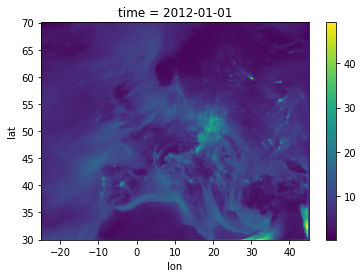

In [21]:
# plotting the 1st daily map
pm10_daily_da[0].plot();

In [22]:
pm10_daily_da.to_netcdf(os.path.join(folder, r'ENSa_2012_PM10_daily.nc'))

## 5. Calculating the number of days characterized by exceedingly high PM10 values, for each place (pixel) in Europe

In [78]:
# reclassifying daily PM10 values
for i in range(0, 366):
    day_na = pm10_daily_da.values[i]
    day_na[day_na<=30] = 0
    day_na[day_na>30] = 1

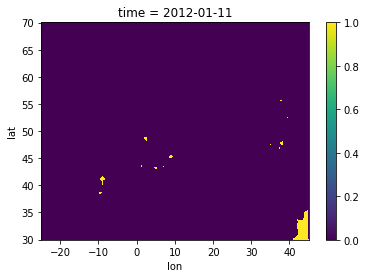

In [79]:
# plotting the 11th day's reclassfied map
pm10_daily_da[10].plot();

In [80]:
# aggregating daily reclassified values by computing the sum over 366 days
pm10_yearly_da = pm10_daily_da.resample(time='1Y').sum()

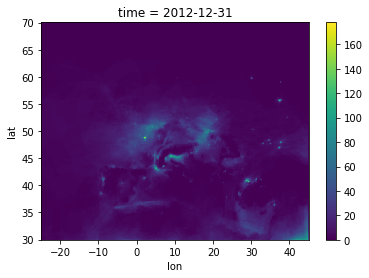

In [81]:
# plotting the final result
pm10_yearly_da.plot();

Comment: We can observe the boundaries of e.g. the Iberian Peninsula, Tyrol and Moscow.

## 6. Saving the result as a TIFF file using GDAL

In [82]:
# defining variables
z_pm10_nn = pm10_yearly_da.values[0]
z_lat_nn = pm10_yearly_da.lat.values
z_lon_nn = pm10_yearly_da.lon.values

In [83]:
# defining coordinate values
xmin, ymin, xmax, ymax = [z_lon_nn.min(), z_lat_nn.min(), z_lon_nn.max(), z_lat_nn.max()]
nrows, ncols = np.shape(z_pm10_nn)
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform = (xmin, xres, 0, ymin, 0, yres)

In [84]:
# defining an empty output model
output_raster = gdal.GetDriverByName('GTiff').Create(os.path.join(folder, r'pm10_exceed_30.tif'), \
                                                     ncols, nrows, 1 ,gdal.GDT_Float32)

In [85]:
# writting model parameters and values 
output_raster.SetGeoTransform(geotransform)  
srs = osr.SpatialReference()                 
srs.ImportFromEPSG(4326)                                                     
output_raster.SetProjection(srs.ExportToWkt())                                             
output_raster.GetRasterBand(1).WriteArray(z_pm10_nn)   
output_raster.FlushCache()